In [1]:
import pandas as pd
# import sys
# sys.path.append("/home/jj2765/DAmFRET_denoising/tomato/")
# import DAmFRETClusteringTools # - NEEDS TO BE SPLIT INTO TINY READ FUNCTION USING FCSPARSER
import NanobodyPaperPlotting
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns



In [2]:
#"globals"
lowBDFPCutoff = 0.75
highBDFPCutoff = 1

colors_decimal = [[120/255, 120/255, 120/255], [249/255, 29/255, 0/255], [32/255, 25/255, 250/255]]

#set plotting limits
#NanobodyPaperPlotting uses 10**n values, but sns.kdeplot uses n values
expressionLims = (10**0.25, 10**3)
BDFPPositiveBDFPSSCLims = (10**-1, 10**3)
BDFPNegativeBDFPSSCLims = (10**-4, 10**1)

expressionLims_kde = (0.25, 3)
BDFPPositiveBDFPSSCLims_kde = (-1, 3)
BDFPNegativeBDFPSSCLims_kde = (-4, 1)

mEosExpressionLabel = "mEos3 concentration (p.d.u.)"
BDFPExpressionLabel = "BDFP concentration (p.d.u.)"

In [3]:
#file helpers
def dataToPlotFromFilelist(files, title):
    """
    handles the single title filelist portion of titledFiles (parameter for DAmFRETRow_files)
    files should be a 1d list of files in population label order
    """
    data = pd.DataFrame()
    for i, file in enumerate(files):
        # populationData = DAmFRETClusteringTools.readDataToDF(file, minAmFRET=-10, maxAmFRET=10, minAmFRETPercentile=0, maxAmFRETPercentile=100, minAcceptorPercentile=0, maxAcceptorPercentile=100, xAxis="log(Acceptor/SSC)")
        populationData = NanobodyPaperPlotting.readDataToDF(file, minAmFRET=-10, maxAmFRET=10, minAmFRETPercentile=0, maxAmFRETPercentile=100, minAcceptorPercentile=0, maxAcceptorPercentile=100, xAxis="log(Acceptor/SSC)")
        populationData["label"] = i
        data = pd.concat([data, populationData])
        
    #These values were decided early on and they should not be function parameters!
    lowBDFPCutoff = 0.75
    highBDFPCutoff = 1
    
    dataLowBDFP = data[data["BDFP1.6-A"] <= (10 ** lowBDFPCutoff)]
    dataHighBDFP = data[data["BDFP1.6-A"] >= (10 ** highBDFPCutoff)]

    if title.lower() == "control" or title.lower() == "x3912b":
        return (dataLowBDFP, "bdfp-")
    else:
        return (dataHighBDFP, "BDFP+")

def DAmFRETRow_files(titledFiles, axs, addTitle=True):
    """
    titledFiles should contain a list of tuples that contain a title and a list of files:
    [(<title>, [<filename for population 0>, <filename for population 1>, ...]), ...]
    """
    for i, (title, files) in enumerate(titledFiles):
        dataToPlot, _ = dataToPlotFromFilelist(files, title)
        
        mEosExpressionLabel = "mEos3 concentration (p.d.u.)"
        if addTitle:
            NanobodyPaperPlotting.plotDAmFRETDensity(dataToPlot["Acceptor/SSC"], dataToPlot["AmFRET"], xlab=mEosExpressionLabel, logX=True, ax=axs[i], xlims=expressionLims, title=title)
        else:
            NanobodyPaperPlotting.plotDAmFRETDensity(dataToPlot["Acceptor/SSC"], dataToPlot["AmFRET"], xlab=mEosExpressionLabel, logX=True, ax=axs[i], xlims=expressionLims)
            

def populationRow_files(titledFiles, axs, expressionRange=None, colors=[[120/255, 120/255, 120/255], [249/255, 29/255, 0/255], [32/255, 25/255, 250/255]]):
    """
    titledFiles should contain a list of tuples that contain a title and a list of files:
    [(<title>, [<filename for population 0>, <filename for population 1>, ...]), ...]
    expressionRange can take a tuple of values between which population size and proportion will be reported on the plots
    """
    for i, (title, files) in enumerate(titledFiles):
        dataToPlot, _ = dataToPlotFromFilelist(files, title)

        mEosExpressionLabel = "mEos3 concentration (p.d.u.)"
        NanobodyPaperPlotting.plotDAmFRETClusters(dataToPlot["Acceptor/SSC"], dataToPlot["AmFRET"], dataToPlot["label"], xlab=mEosExpressionLabel, logX=True, ax=axs[i], xlims=expressionLims, title=title, colors=colors)

        #handle expressionRange
        if expressionRange is not None:
            axs[i].vlines(expressionRange, -0.2, 2, color="red", linestyles="-.")
            dataWithinBin = dataToPlot[(dataToPlot["Acceptor/SSC"] >= expressionRange[0]) & (dataToPlot["Acceptor/SSC"] <= expressionRange[1])]
            labels, labelCounts = np.unique(dataWithinBin["label"], return_counts=True)
        else:
            # labels, labelCounts = np.unique(dataToPlot["label"], return_counts=True)
            continue #NanobodyPaaperPlotting.plotDAmFRETClusters has been updated to have good default posiitoning
            
        labelCountDict = dict(zip(labels, labelCounts))
        
        #remove default text
        for text in axs[i].texts:
            text.set_visible(False)
        
        #add better text
        textX = 0.01
        textYMax = 0.98
        #make the label for the highest pop
        label = labels.max()
        higherText = axs[i].text(textX, textYMax, f"{labelCountDict[label]}, {labelCountDict[label] / sum(labelCountDict.values()):.2f}", va="top", ha="left", color=colors[label], transform = axs[i].transAxes)
        
        #make label for non-highest pop(s)
        for label in labels[-2::-1]:
            higherText = axs[i].annotate(f"{labelCountDict[label]}, {labelCountDict[label] / sum(labelCountDict.values()):.2f}", xycoords=higherText, xy=(0,-1), color=colors[label], horizontalalignment="left", transform = axs[i].transAxes)

def contourRow_files(titledFiles, axs, labels=None, colors=[[120/255, 120/255, 120/255], [249/255, 29/255, 0/255], [32/255, 25/255, 250/255]], labelColumn="label", hueOrder=None):
    """
    titledFiles should contain a list of tuples that contain a title and a list of files:
    [(<title>, [<filename for population 0>, <filename for population 1>, ...]), ...]
    expressionRange can take a tuple of values between which population size and proportion will be reported on the plots
    """
    # print("SKIPPING DURING TESTING")
    # return
    
    for i, (title, files) in enumerate(titledFiles):
        dataToPlot, BDFPExpressionGroup = dataToPlotFromFilelist(files, title)

        expressionLims = (10**0.25, 10**3)
        BDFPPositiveBDFPSSCLims = (10**-1, 10**3)
        BDFPNegativeBDFPSSCLims = (10**-4, 10**1)
        
        expressionLims_kde = (0.25, 3)
        BDFPPositiveBDFPSSCLims_kde = (-1, 3)
        BDFPNegativeBDFPSSCLims_kde = (-4, 1)
        
        if BDFPExpressionGroup == "BDFP+":
            ylims = BDFPPositiveBDFPSSCLims_kde
        else:
            ylims = BDFPNegativeBDFPSSCLims_kde

        #labels hasn't ben hanlded yet
        if labels is None:
            NanobodyPaperPlotting.plotBDFPAcceptorContours_test(dataToPlot, labelColumn=labelColumn, ax=axs[i], colors=colors, ylims=ylims, xlims=expressionLims_kde, hueOrder=hueOrder)
        else:
            NanobodyPaperPlotting.plotBDFPAcceptorContours_test(dataToPlot[dataToPlot[labelColumn].isin(labels)], labelColumn=labelColumn, ax=axs[i], colors=colors, ylims=ylims, xlims=expressionLims_kde, hueOrder=hueOrder)

        mEosExpressionLabel = "mEos3 concentration (p.d.u.)"
        BDFPExpressionLabel = "BDFP concentration (p.d.u.)"
        
        axs[i].set_xlabel(mEosExpressionLabel)
        axs[i].set_ylabel(BDFPExpressionLabel)

        axs[i].set_xlim(expressionLims)
        axs[i].set_ylim((10**ylims[0], 10**ylims[1]))

def contourPlot_data(data, ax, labels=None, colors=[[120/255, 120/255, 120/255], [249/255, 29/255, 0/255], [32/255, 25/255, 250/255]], labelColumn="label", ylims=None, hueOrder=None):
    expressionLims = (10**0.25, 10**3)
    BDFPPositiveBDFPSSCLims = (10**-1, 10**3)
    BDFPNegativeBDFPSSCLims = (10**-4, 10**1)
    
    expressionLims_kde = (0.25, 3)
    BDFPPositiveBDFPSSCLims_kde = (-1, 3)
    BDFPNegativeBDFPSSCLims_kde = (-4, 1)
    mEosExpressionLabel = "mEos3 concentration (p.d.u.)"
    BDFPExpressionLabel = "BDFP concentration (p.d.u.)"


    if labels is None:
        if data["BDFP1.6-A"].min() > 10 ** lowBDFPCutoff:
            #BDFP+ for sure if min is above the lower cutoff
            NanobodyPaperPlotting.plotBDFPAcceptorContours_test(data, labelColumn=labelColumn, ax=ax, colors=colors, ylims=BDFPPositiveBDFPSSCLims_kde, xlims=expressionLims_kde, hueOrder=hueOrder)
            ax.set_ylim(BDFPPositiveBDFPSSCLims)
        else:
            NanobodyPaperPlotting.plotBDFPAcceptorContours_test(data, labelColumn=labelColumn, ax=ax, colors=colors, ylims=BDFPNegativeBDFPSSCLims_kde, xlims=expressionLims_kde, hueOrder=hueOrder)
            ax.set_ylim(BDFPNegativeBDFPSSCLims)

    else:
        if data["BDFP1.6-A"].min() > 10 ** lowBDFPCutoff:
            #BDFP+ for sure if min is above the lower cutoff
            NanobodyPaperPlotting.plotBDFPAcceptorContours(data[data[labelColumn].isin(labels)], labelColumn=labelColumn, ax=ax, colors=colors, ylims=BDFPPositiveBDFPSSCLims_kde, xlims=expressionLims_kde)
            ax.set_ylim(BDFPPositiveBDFPSSCLims)
        else:
            NanobodyPaperPlotting.plotBDFPAcceptorContours(data[data[labelColumn].isin(labels)], labelColumn=labelColumn, ax=ax, colors=colors, ylims=BDFPNegativeBDFPSSCLims_kde, xlims=expressionLims_kde)
            ax.set_ylim(BDFPNegativeBDFPSSCLims)

    ax.set_xlim(expressionLims)
    ax.set_xlabel(mEosExpressionLabel)
    ax.set_ylabel(BDFPExpressionLabel)
        
        

    

In [4]:
def changeValencyFigTitles(fig, axs, leftShift=0):
    NBlabels = ["Control", "1x mEosNb", "2x mEosNb", "3x mEosNb", "4x mEosNb", "5x mEosNb", "6x mEosNb"]
    mEosLabels = ["1x mEos3", "2x mEos3", "3x mEos3", "4x mEos3"]
    
    for i, NBlabel in enumerate(NBlabels):
       titleText = axs[0,i].set_title(NBlabel)
    
    titleSize = titleText.get_fontsize()

    #remove any row titles that already exist
    for i in range(4):
        for text in axs[i,0].texts:
            if text.get_text() in mEosLabels:
                text.set_visible(False)
    
    for i, mEosLabel in enumerate(mEosLabels):
        axs[i,0].text(-0.25 - leftShift, 0.5, mEosLabel, transform=axs[i,0].transAxes, ha="center", va="center", rotation_mode="anchor", rotation=90, fontsize=titleSize)

In [5]:
# plot labelers
def linearLabeling_2x(data):
    #divides blue from gray
    bottomSlope = 0.17
    bottomIntercept = -0.11

    #divides red from gray
    minTopX = 1.5
    topSlope = 0.14
    topIntercept = 0.16

    indexesInBottom = (data["AmFRET"] - (np.log10(data["Acceptor/SSC"]) * bottomSlope + bottomIntercept)) < 0
    indexesInTop = (data["AmFRET"] - (np.log10(data["Acceptor/SSC"]) * topSlope + topIntercept)) > 0
    
    data["linearLabel"] = 0
    data.loc[indexesInBottom, "linearLabel"] = 2
    #top division does not include low mEos expression
    data.loc[(indexesInTop & (data["Acceptor/SSC"] > 10 ** minTopX)), "linearLabel"] = 1

    return data


def linearLabeling_3x(data):
    #divides blue from gray
    bottomSlope = 0.16
    bottomIntercept = 0.01

    #divides red from gray
    minTopX = 1.3
    topSlope = 0.13
    topIntercept = 0.30

    indexesInBottom = (data["AmFRET"] - (np.log10(data["Acceptor/SSC"]) * bottomSlope + bottomIntercept)) < 0
    indexesInTop = (data["AmFRET"] - (np.log10(data["Acceptor/SSC"]) * topSlope + topIntercept)) > 0
    
    data["linearLabel"] = 0
    data.loc[indexesInBottom, "linearLabel"] = 2
    #top division does not include low mEos expression
    data.loc[(indexesInTop & (data["Acceptor/SSC"] > 10 ** minTopX)), "linearLabel"] = 1

    return data

def linearLabeling_4x(data):
    #divides blue from gray
    bottomSlope = 0.13
    bottomIntercept = 0.13

    #divides red from gray
    minTopX = 1.1 #in log10(Acceptor/SSC)
    topSlope = 0.13
    topIntercept = 0.30

    indexesInBottom = (data["AmFRET"] - (np.log10(data["Acceptor/SSC"]) * bottomSlope + bottomIntercept)) < 0
    indexesInTop = (data["AmFRET"] - (np.log10(data["Acceptor/SSC"]) * topSlope + topIntercept)) > 0
    
    data["linearLabel"] = 0
    data.loc[indexesInBottom, "linearLabel"] = 2
    #top division does not include low mEos expression
    data.loc[(indexesInTop & (data["Acceptor/SSC"] > 10 ** minTopX)), "linearLabel"] = 1

    return data


In [6]:
# mEos1xFiles = [("Control", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate1/A1.fcs"]),
#                 ("1x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate2/G1.fcs"]),
#                 ("2x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate2/H1.fcs"]),
#                 ("3x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/A1.fcs"]),
#                 ("4x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/B1.fcs"]),
#                 ("5x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/C1.fcs"]),
#                 ("6x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/D1.fcs"]),
#               ]

# mEos2xFiles = [("Control", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate1/A2.fcs"]),
#                 ("1x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate2/G2.fcs"]),
#                 ("2x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate2/H2.fcs"]),
#                 ("3x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/A2.fcs"]),
#                 ("4x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/B2.fcs"]),
#                 ("5x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/C2.fcs"]),
#                 ("6x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/D2.fcs"]),
#               ]

# mEos3xFiles = [("Control", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate1/A3.fcs"]),
#                 ("1x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate2/G3.fcs"]),
#                 ("2x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate2/H3.fcs"]),
#                 ("3x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/A3.fcs"]),
#                 ("4x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/B3.fcs"]),
#                 ("5x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/C3.fcs"]),
#                 ("6x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/D3.fcs"]),
#               ]

# mEos4xFiles = [("Control", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate1/A4.fcs"]),
#                 ("1x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate2/G4.fcs"]),
#                 ("2x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate2/H4.fcs"]),
#                 ("3x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/A4.fcs"]),
#                 ("4x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/B4.fcs"]),
#                 ("5x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/C4.fcs"]),
#                 ("6x mEosNb", ["/n/core/cyto/_Data/Halfmann/hk2674/mEos_NB_single_and_double_plasmids/gated_and_compensated/exported_plate3/D4.fcs"]),
#               ]

In [7]:
mEos1xFiles = [("Control", ["data/mEosValency/exported_plate1/A1.fcs"]),
                ("1x mEosNb", ["data/mEosValency/exported_plate2/G1.fcs"]),
                ("2x mEosNb", ["data/mEosValency/exported_plate2/H1.fcs"]),
                ("3x mEosNb", ["data/mEosValency/exported_plate3/A1.fcs"]),
                ("4x mEosNb", ["data/mEosValency/exported_plate3/B1.fcs"]),
                ("5x mEosNb", ["data/mEosValency/exported_plate3/C1.fcs"]),
                ("6x mEosNb", ["data/mEosValency/exported_plate3/D1.fcs"]),
              ]

mEos2xFiles = [("Control", ["data/mEosValency/exported_plate1/A2.fcs"]),
                ("1x mEosNb", ["data/mEosValency/exported_plate2/G2.fcs"]),
                ("2x mEosNb", ["data/mEosValency/exported_plate2/H2.fcs"]),
                ("3x mEosNb", ["data/mEosValency/exported_plate3/A2.fcs"]),
                ("4x mEosNb", ["data/mEosValency/exported_plate3/B2.fcs"]),
                ("5x mEosNb", ["data/mEosValency/exported_plate3/C2.fcs"]),
                ("6x mEosNb", ["data/mEosValency/exported_plate3/D2.fcs"]),
              ]

mEos3xFiles = [("Control", ["data/mEosValency/exported_plate1/A3.fcs"]),
                ("1x mEosNb", ["data/mEosValency/exported_plate2/G3.fcs"]),
                ("2x mEosNb", ["data/mEosValency/exported_plate2/H3.fcs"]),
                ("3x mEosNb", ["data/mEosValency/exported_plate3/A3.fcs"]),
                ("4x mEosNb", ["data/mEosValency/exported_plate3/B3.fcs"]),
                ("5x mEosNb", ["data/mEosValency/exported_plate3/C3.fcs"]),
                ("6x mEosNb", ["data/mEosValency/exported_plate3/D3.fcs"]),
              ]

mEos4xFiles = [("Control", ["data/mEosValency/exported_plate1/A4.fcs"]),
                ("1x mEosNb", ["data/mEosValency/exported_plate2/G4.fcs"]),
                ("2x mEosNb", ["data/mEosValency/exported_plate2/H4.fcs"]),
                ("3x mEosNb", ["data/mEosValency/exported_plate3/A4.fcs"]),
                ("4x mEosNb", ["data/mEosValency/exported_plate3/B4.fcs"]),
                ("5x mEosNb", ["data/mEosValency/exported_plate3/C4.fcs"]),
                ("6x mEosNb", ["data/mEosValency/exported_plate3/D4.fcs"]),
              ]

In [8]:
squarePlotSize = 3
numCols = 7
numRows = 4



/home/jj2765/miniconda3/envs/DAmFRET_clustering_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/jj2765/miniconda3/envs/DAmFRET_clustering_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/home/jj2765/miniconda3/envs/DAmFRET_clustering_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/jj2765/miniconda3/envs/DAmFRET_clustering_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/home/jj2765/miniconda3/envs/DAmFRET_clustering_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered


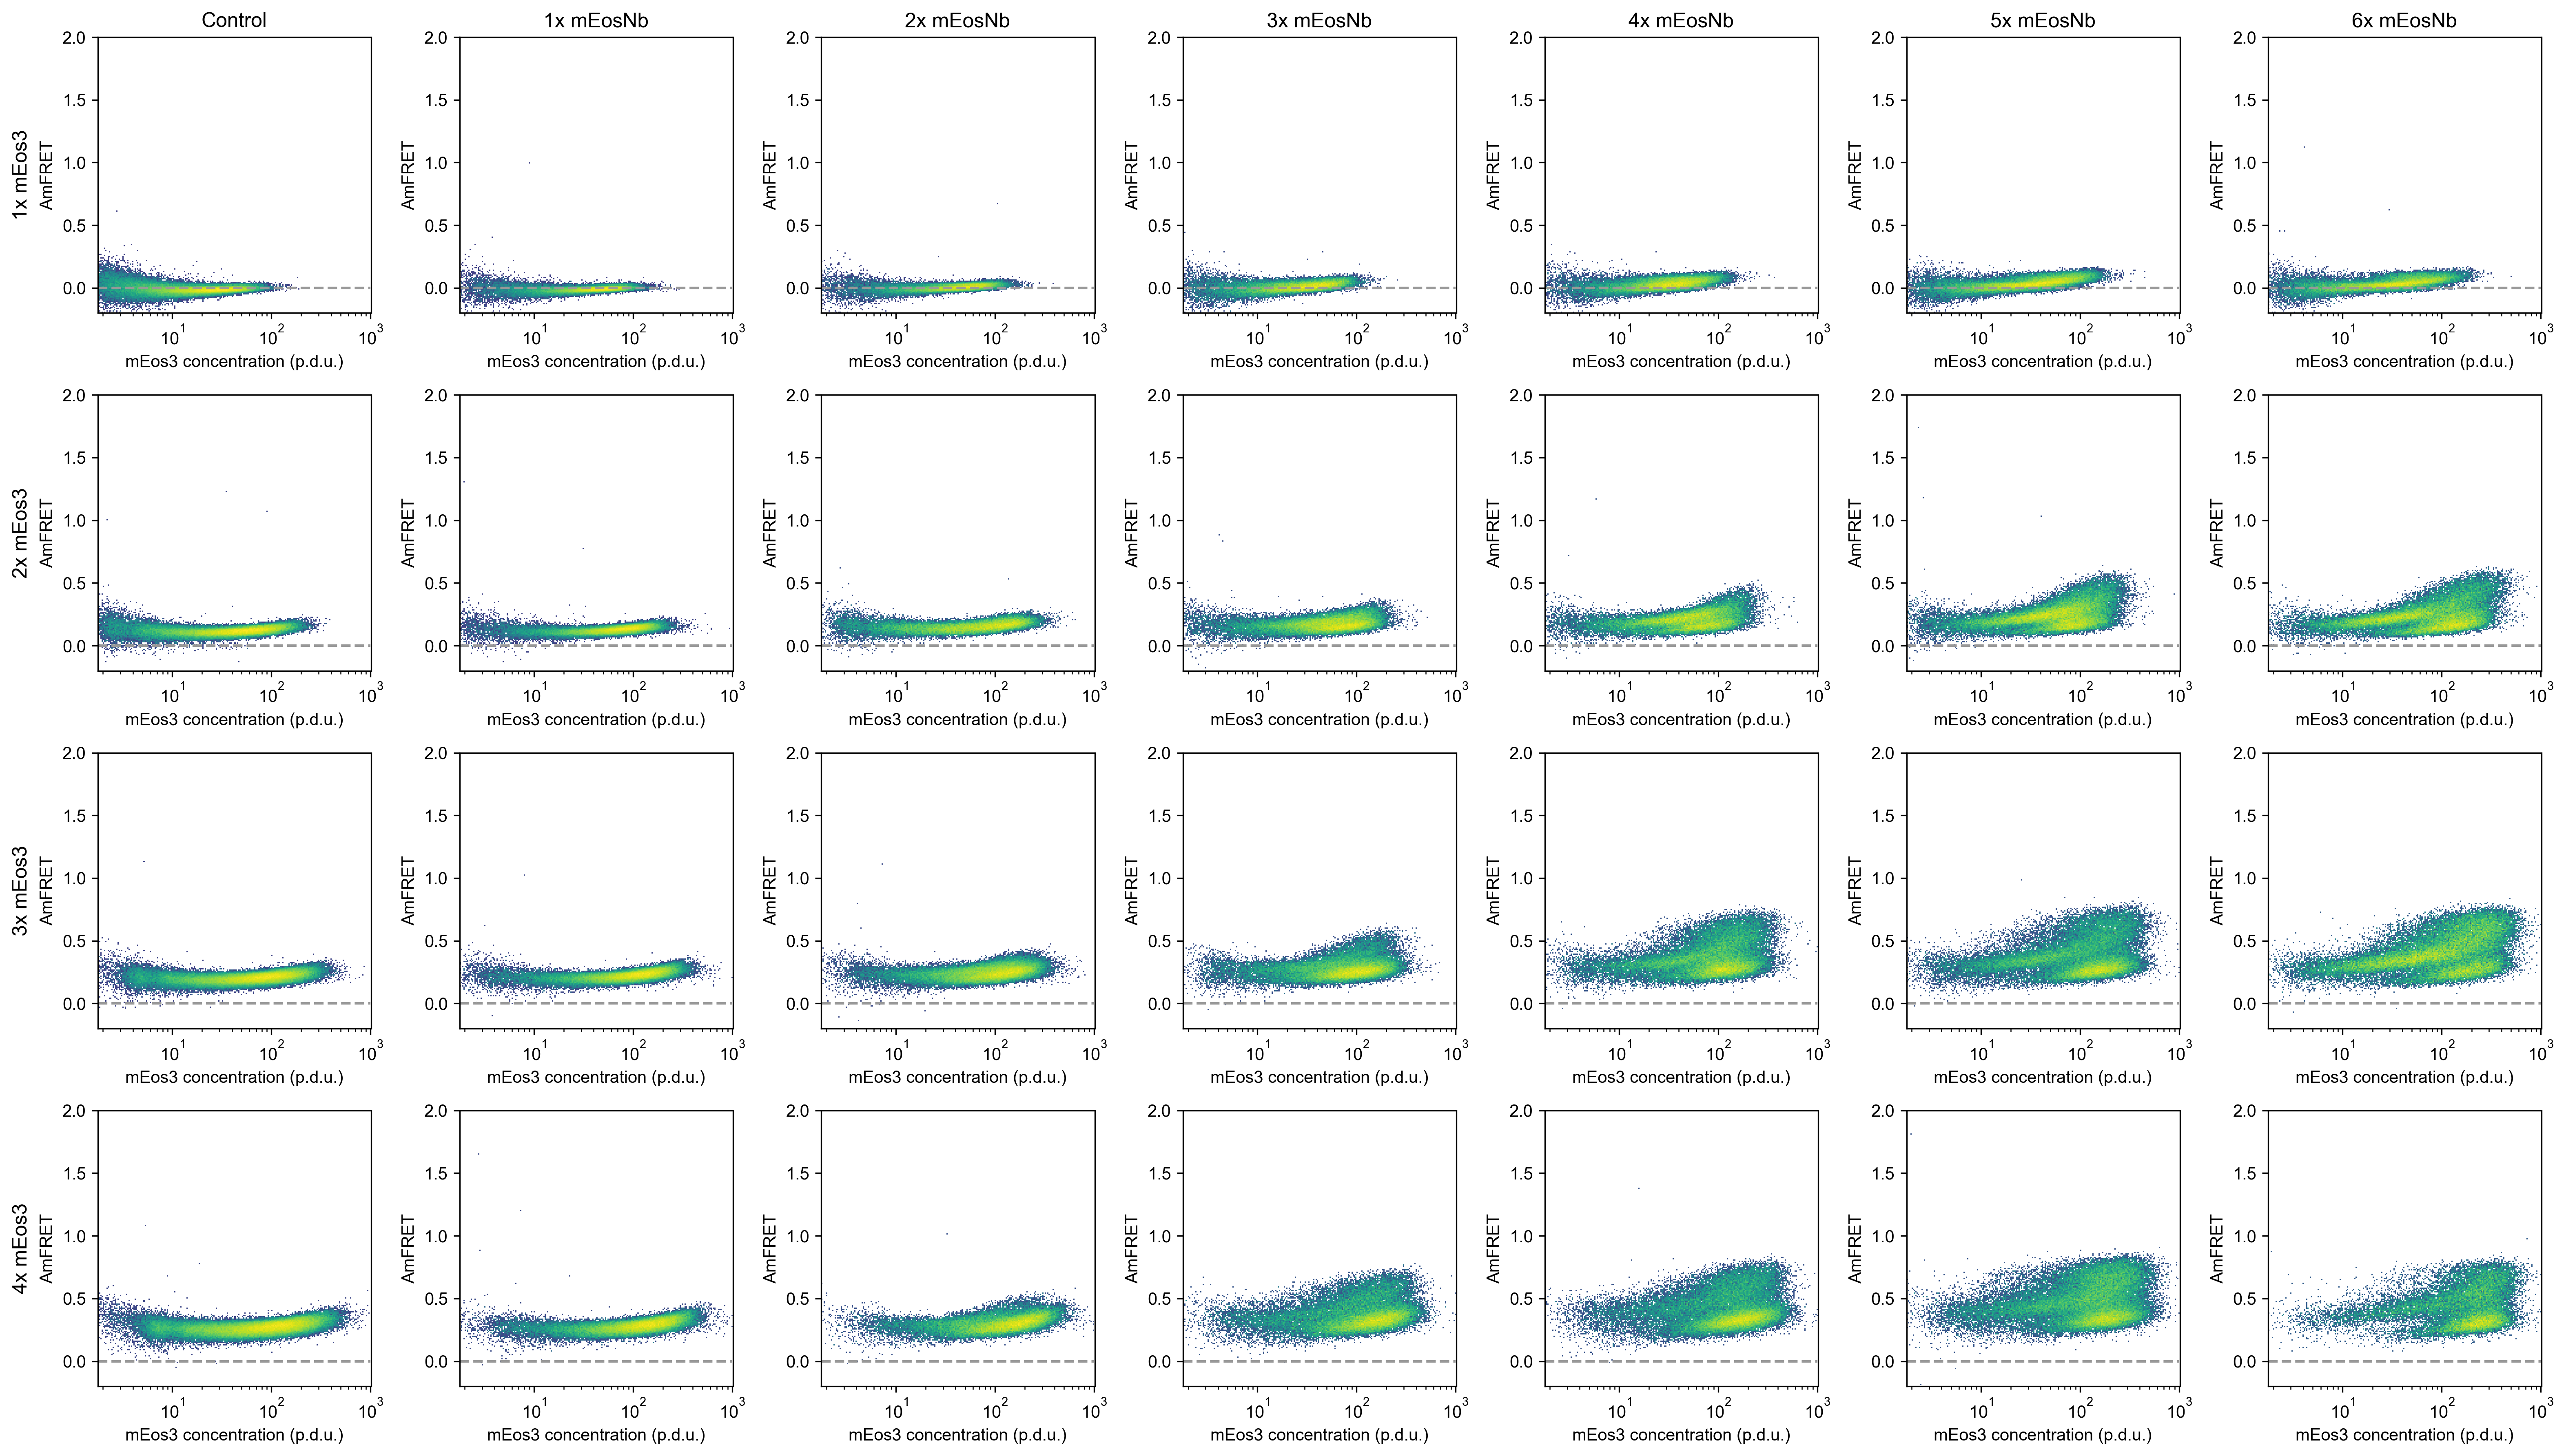

In [9]:
plt.show()

DAmFRETFig = plt.Figure((squarePlotSize*numCols ,squarePlotSize*numRows), dpi=300)
DAmFRETAxs = DAmFRETFig.subplots(numRows,numCols, subplot_kw={'projection': "scatter_density"})

DAmFRETRow_files(mEos1xFiles, DAmFRETAxs[0], addTitle=True)
DAmFRETRow_files(mEos2xFiles, DAmFRETAxs[1], addTitle=False)
DAmFRETRow_files(mEos3xFiles, DAmFRETAxs[2], addTitle=False)
DAmFRETRow_files(mEos4xFiles, DAmFRETAxs[3], addTitle=False)

changeValencyFigTitles(DAmFRETFig, DAmFRETAxs, leftShift=0.03)

DAmFRETFig.tight_layout()
DAmFRETFig

In [10]:
# DAmFRETFig.savefig("plots/valencySeries_DAmFRET.png")

In [11]:
populationsFig = plt.Figure((squarePlotSize*numCols ,squarePlotSize*numRows), dpi=300)
populationsAxs = populationsFig.subplots(numRows,numCols, subplot_kw={'projection': "scatter_density"})

linearLabelOrder = [1,0,2]

for i, (testTitle, testFiles) in enumerate(mEos1xFiles):
    data, _ = dataToPlotFromFilelist(testFiles, testTitle)
    data["linearLabel"] = 0
    
    # data = linearLabeling_1x(data)
    
    # if testTitle == "Control" or int(testTitle[0]) < 3:
    #     data["linearLabel"] = 0
    dataLabelOrder = [label for label in linearLabelOrder if label in data["linearLabel"].values]
    # NanobodyPaperPlotting.plotDAmFRETClusters(data["Acceptor/SSC"], data["AmFRET"], data["linearLabel"], xlab=mEosExpressionLabel, logX=True, xlims=expressionLims, title=testTitle, colors=colors_decimal, ax=populationsAxs[0,i], labelOrder=dataLabelOrder)
    NanobodyPaperPlotting.plotDAmFRETClusters(data["Acceptor/SSC"], data["AmFRET"], data["linearLabel"], xlab=mEosExpressionLabel, logX=True, xlims=expressionLims, colors=colors_decimal, ax=populationsAxs[0,i], labelOrder=dataLabelOrder)


for i, (testTitle, testFiles) in enumerate(mEos2xFiles):
    data, _ = dataToPlotFromFilelist(testFiles, testTitle)
    data = linearLabeling_2x(data)
    
    if testTitle == "Control" or int(testTitle[0]) < 3:
        data["linearLabel"] = 0
    dataLabelOrder = [label for label in linearLabelOrder if label in data["linearLabel"].values]
    # NanobodyPaperPlotting.plotDAmFRETClusters(data["Acceptor/SSC"], data["AmFRET"], data["linearLabel"], xlab=mEosExpressionLabel, logX=True, xlims=expressionLims, title=testTitle, colors=colors_decimal, ax=populationsAxs[1,i], labelOrder=dataLabelOrder)
    NanobodyPaperPlotting.plotDAmFRETClusters(data["Acceptor/SSC"], data["AmFRET"], data["linearLabel"], xlab=mEosExpressionLabel, logX=True, xlims=expressionLims, colors=colors_decimal, ax=populationsAxs[1,i], labelOrder=dataLabelOrder)

for i, (testTitle, testFiles) in enumerate(mEos3xFiles):
    data, _ = dataToPlotFromFilelist(testFiles, testTitle)
    data = linearLabeling_3x(data)
    
    if testTitle == "Control" or int(testTitle[0]) < 2:
        data["linearLabel"] = 0
    dataLabelOrder = [label for label in linearLabelOrder if label in data["linearLabel"].values]
    # NanobodyPaperPlotting.plotDAmFRETClusters(data["Acceptor/SSC"], data["AmFRET"], data["linearLabel"], xlab=mEosExpressionLabel, logX=True, xlims=expressionLims, title=testTitle, colors=colors_decimal, ax=populationsAxs[2,i], labelOrder=dataLabelOrder)
    NanobodyPaperPlotting.plotDAmFRETClusters(data["Acceptor/SSC"], data["AmFRET"], data["linearLabel"], xlab=mEosExpressionLabel, logX=True, xlims=expressionLims, colors=colors_decimal, ax=populationsAxs[2,i], labelOrder=dataLabelOrder)

for i, (testTitle, testFiles) in enumerate(mEos4xFiles):
    data, _ = dataToPlotFromFilelist(testFiles, testTitle)
    data = linearLabeling_4x(data)
    
    if testTitle == "Control" or int(testTitle[0]) < 2:
        data["linearLabel"] = 0
    dataLabelOrder = [label for label in linearLabelOrder if label in data["linearLabel"].values]
    # NanobodyPaperPlotting.plotDAmFRETClusters(data["Acceptor/SSC"], data["AmFRET"], data["linearLabel"], xlab=mEosExpressionLabel, logX=True, xlims=expressionLims, title=testTitle, colors=colors_decimal, ax=populationsAxs[3,i], labelOrder=dataLabelOrder)
    NanobodyPaperPlotting.plotDAmFRETClusters(data["Acceptor/SSC"], data["AmFRET"], data["linearLabel"], xlab=mEosExpressionLabel, logX=True, xlims=expressionLims, colors=colors_decimal, ax=populationsAxs[3,i], labelOrder=dataLabelOrder)

In [12]:
changeValencyFigTitles(populationsFig, populationsAxs, leftShift=0.03)

populationsFig.tight_layout()
populationsFig


KeyboardInterrupt



In [ ]:
# populationsFig.savefig("plots/valencySeries_populations.png")

In [ ]:
phaseFig = plt.Figure((squarePlotSize*numCols ,squarePlotSize*numRows))
phaseAxs = phaseFig.subplots(numRows, numCols)

hueOrder = [0,2,1]

for i, (testTitle, testFiles) in enumerate(mEos1xFiles):
    data, bdfpGroup = dataToPlotFromFilelist(testFiles, testTitle)
    data["linearLabel"] = 0
    
    # data = linearLabeling_1x(data)
    
    # if testTitle == "Control" or int(testTitle[0]) < 3:
    #     data["linearLabel"] = 0
    dataHueOrder = [item for item in hueOrder if item in data["linearLabel"].values]
    contourPlot_data(data, phaseAxs[0,i],  colors=colors_decimal, labelColumn="linearLabel", hueOrder=dataHueOrder)
        


for i, (testTitle, testFiles) in enumerate(mEos2xFiles):
    data, _ = dataToPlotFromFilelist(testFiles, testTitle)
    data = linearLabeling_2x(data)
    
    if testTitle == "Control" or int(testTitle[0]) < 3:
        data["linearLabel"] = 0
    dataHueOrder = [item for item in hueOrder if item in data["linearLabel"].values]
    contourPlot_data(data, phaseAxs[1,i],  colors=colors_decimal, labelColumn="linearLabel", hueOrder=dataHueOrder)
        

for i, (testTitle, testFiles) in enumerate(mEos3xFiles):
    data, _ = dataToPlotFromFilelist(testFiles, testTitle)
    data = linearLabeling_3x(data)
    
    if testTitle == "Control" or int(testTitle[0]) < 2:
        data["linearLabel"] = 0
    dataHueOrder = [item for item in hueOrder if item in data["linearLabel"].values]
    contourPlot_data(data, phaseAxs[2,i],  colors=colors_decimal, labelColumn="linearLabel", hueOrder=dataHueOrder)
        

for i, (testTitle, testFiles) in enumerate(mEos4xFiles):
    data, _ = dataToPlotFromFilelist(testFiles, testTitle)
    data = linearLabeling_4x(data)
    
    if testTitle == "Control" or int(testTitle[0]) < 2:
        data["linearLabel"] = 0
    dataHueOrder = [item for item in hueOrder if item in data["linearLabel"].values]
    contourPlot_data(data, phaseAxs[3,i],  colors=colors_decimal, labelColumn="linearLabel", hueOrder=dataHueOrder)
        


In [ ]:
changeValencyFigTitles(phaseFig, phaseAxs, leftShift=0.07)


phaseFig.tight_layout()
phaseFig

In [ ]:
# phaseFig.savefig("plots/valencySeries_contours.png")

In [ ]:
mEos1Data, _ = dataToPlotFromFilelist(mEos1xFiles[0][1], mEos1xFiles[0][0])
mEos2Data, _ = dataToPlotFromFilelist(mEos2xFiles[0][1], mEos2xFiles[0][0])
mEos3Data, _ = dataToPlotFromFilelist(mEos3xFiles[0][1], mEos3xFiles[0][0])
mEos4Data, _ = dataToPlotFromFilelist(mEos4xFiles[0][1], mEos4xFiles[0][0])

mEos1Data["mEosN"] = 1
mEos2Data["mEosN"] = 2
mEos3Data["mEosN"] = 3
mEos4Data["mEosN"] = 4

combinedData = pd.concat([mEos1Data, mEos2Data, mEos3Data, mEos4Data])

In [ ]:
blueColors = ["", "#4A566A", "#2D5C78", "#3971A5", "#3FABFF"]

fig = plt.Figure((3,3), dpi=300)
ax = fig.add_subplot(projection = "scatter_density")

NanobodyPaperPlotting.plotDAmFRETClusters(combinedData["Acceptor/SSC"], combinedData["AmFRET"], combinedData["mEosN"], logX=True, colors=blueColors, xlims=expressionLims, ax=ax)
# NanobodyPaperPlotting.plotDAmFRETClusters(combinedData["Acceptor/SSC"], combinedData["AmFRET"], combinedData["mEosN"], logX=True, colors=blueColors, ylims=(-0.2,0.6), xlims=expressionLims, ax=ax)

for text in ax.texts:
    text.set_visible(False)
    
plt.show()
# fig

labels = ["4x mEos3", "3x mEos3", "2x mEos3", "1x mEos3"]

textX = 0.01
textYMax = 0.98
#make the label for the highest pop
label = labels[0]
higherText = ax.text(textX, textYMax, label, va="top", ha="left", color=blueColors[int(label[0])], transform = ax.transAxes)

#make label for non-highest pop(s)
for i, label in enumerate(labels[1:]):
    higherText = ax.annotate(label, xycoords=higherText, xy=(0,-1), color=blueColors[int(label[0])], horizontalalignment="left", transform = ax.transAxes)

fig.tight_layout()
fig

In [ ]:
# fig.savefig("plots/mEosSeries.png")